**About** : This notebook is used to train models.

Ideas :
- https://www.kaggle.com/c/open-images-2019-instance-segmentation/discussion/110983

- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95247#latest-567841
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95233#latest-551075
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95234#latest-555537

- https://www.kaggle.com/c/airbus-ship-detection/discussion/71595#latest-457550
- https://www.kaggle.com/c/airbus-ship-detection/discussion/71667#latest-558876

In [31]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
cd ../src/

/home/theo/Documents/sartorius/src


## Initialization

### Imports

In [33]:
import gc
import os
import ast
import sys
import cv2
import glob
import json
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter("ignore", UserWarning)

In [34]:
from params import *
from utils.plots import *

from utils.logger import Config
from inference.main import inference_test

## Exp

In [35]:
EXP_FOLDER = LOG_PATH + "2021-11-03/9/"

## Data

In [36]:
df = pd.read_csv(DATA_PATH + "sample_submission.csv")
df['img_path'] = DATA_PATH + "test/" + df['id'] + ".png"

In [37]:
config = Config(json.load(open(EXP_FOLDER + "config.json", 'r')))
config.model_config = EXP_FOLDER + config.model_config.split('/')[-1]
config.data_config = EXP_FOLDER + config.data_config.split('/')[-1]

weights = sorted(glob.glob(EXP_FOLDER + "*.pt"))

## Main

In [23]:
results = inference_test(df, config, weights)


 -> Loading weights from ../input/weights/mask_rcnn_r50_fpn_mstrain-poly_3x_coco.pth


 -> Loading weights from ../logs/2021-11-03/9/maskrcnn_0.pt



## Viz

In [24]:
threshold = 0.5
max_size = 1500
fold = 0

In [25]:
pipelines = define_pipelines(config.data_config)
dataset = SartoriusInferenceDataset(df, transforms=pipelines['test_viz'])

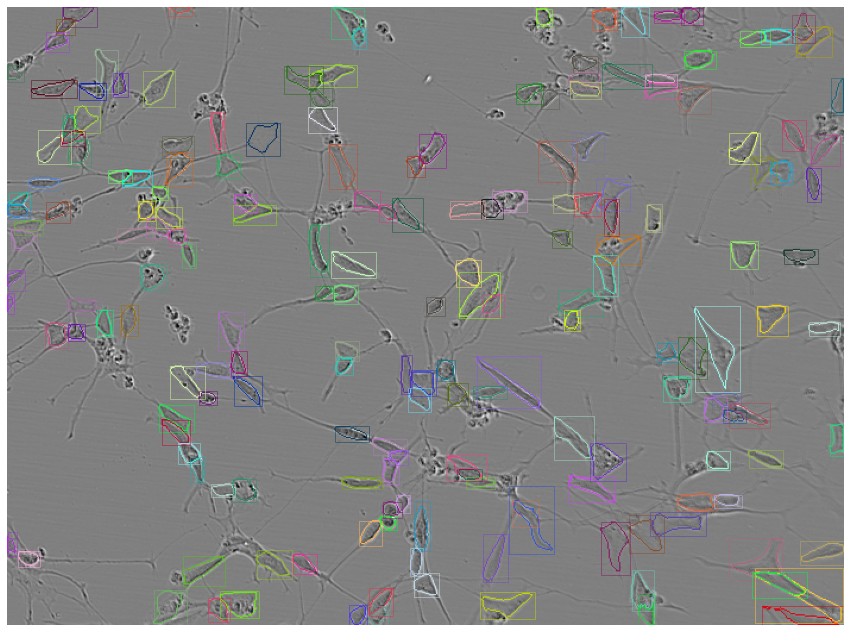

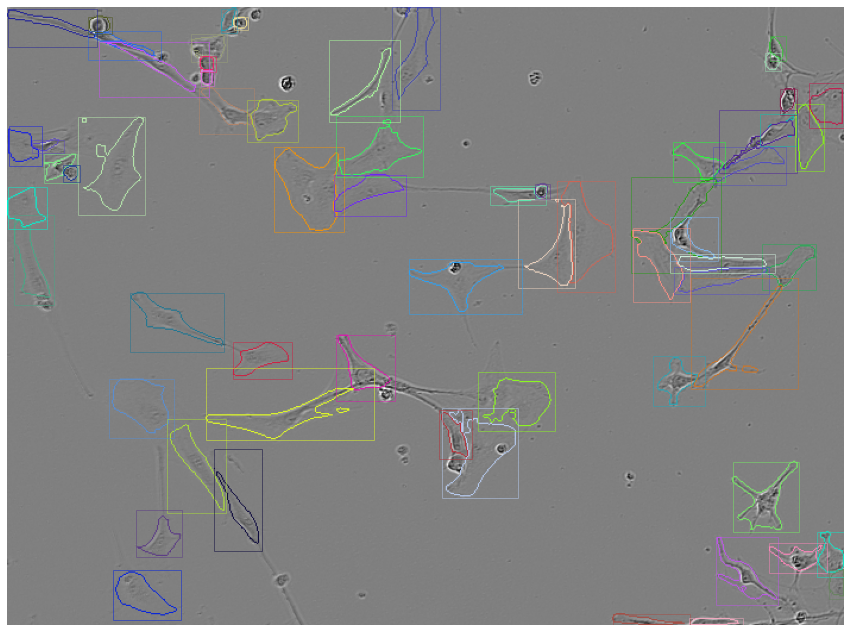

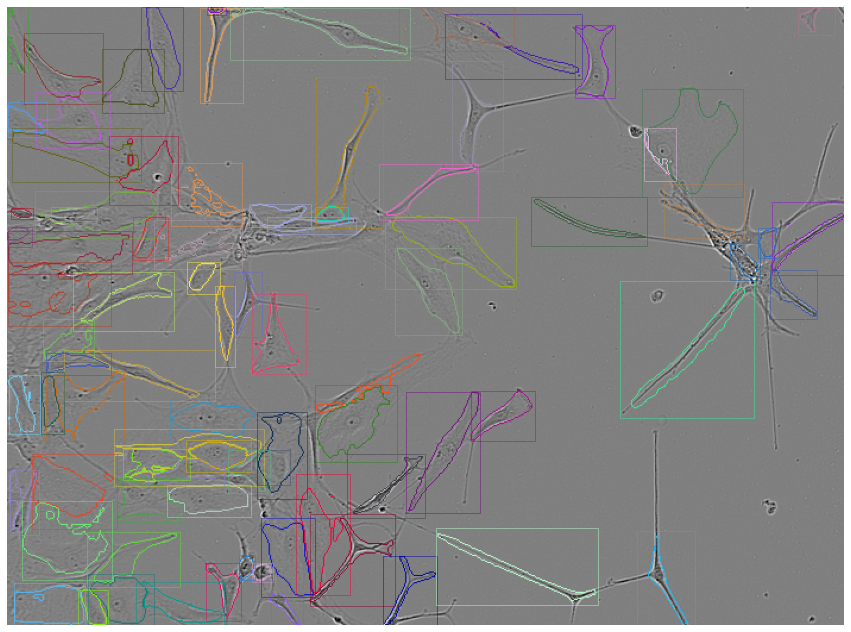

In [26]:
for idx in range(len(dataset)):
    data = dataset[idx]

    img = data['img']
    
    # preds
    boxes = np.concatenate(results[fold][idx][0])
    masks = np.concatenate(results[fold][idx][1]).astype(int)
    masks = masks[boxes[:, -1] > threshold]
    boxes = boxes[boxes[:, -1] > threshold]
    
    sizes = np.max([boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]], 0)
    masks = masks[sizes < max_size]
    boxes = boxes[sizes < max_size]

    pred = masks.copy().astype(int)
    for i in range(len(pred)):
        pred[i] *= (i + 1)
    pred = pred.max(0)

    plt.figure(figsize=(15, 15))
    plot_sample(img, pred, boxes, plotly=False)
    plt.axis(False)
    plt.show()
